In [2]:
import matplotlib.pyplot as plt
import env.guide_sim as gs
import params
import torch
import torchvision.transforms as transforms
import random
import os

pygame-ce 2.5.0 (SDL 2.30.3, Python 3.10.0)


## 加载导丝仿真环境

In [3]:
dataset_path = "datas/exvivo/"
tasks = os.listdir(os.path.join(dataset_path, "task"))
tasks = [os.path.join(dataset_path, "task", t) for t in tasks]
env = gs.GuidewireEnv(tasks[0])

## 尝试加载导丝环境

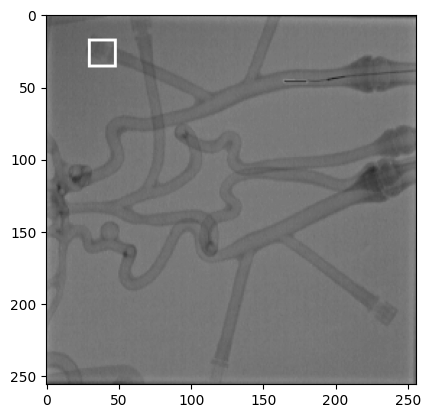

In [4]:
img = env.reset()  # 重置环境（每次要开始交互之前必须这么做）（输入代表根据序号开启某个任务）
plt.imshow(img[0], cmap='gray')

## 图片做域随机化处理


In [5]:
# 定义转换管道，包括域随机化
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机改变颜色属性
    transforms.RandomResizedCrop(size= (256, 256), scale=(0.95, 1.0)),  # 随机裁剪并调整大小
    transforms.RandomRotation(degrees=2),  # 随机旋转
])


c:\Users\m9291\.conda\envs\torch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


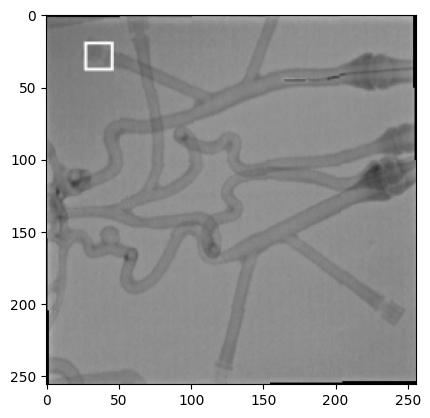

In [6]:
tensor = torch.from_numpy(img)
tensor = transform(tensor)
tensor.shape
plt.imshow(tensor[0], cmap='gray')

## 尝试交互 (往前推进十次)

0 0.0 False [93, 339]
1 0.0 False [89, 339]
2 0.0 False [89, 329]
3 0.0 False [92, 339]
4 0.0 False [89, 329]
5 0.0 False [79, 333]
6 0.0 False [91, 339]
7 0.0 False [83, 343]
8 0.0 False [86, 341]
9 0.0 False [86, 330]
10 0.0 False [84, 320]
11 0.0 False [89, 307]
12 0.0 False [84, 320]
13 0.0 False [86, 330]
14 0.0 False [85, 330]
15 0.0 False [85, 319]
16 0.0 False [93, 317]
17 0.0 False [93, 328]
18 0.0 False [93, 328]
19 0.0 False [93, 328]
20 0.0 False [93, 328]
21 0.0 False [98, 321]
22 0.0 False [98, 318]
23 0.0 False [98, 319]
24 0.0 False [98, 319]
25 0.0 False [98, 318]
26 0.0 False [93, 329]
27 0.0 False [93, 329]
28 0.0 False [96, 340]
29 0.0 False [98, 340]
30 0.0 False [93, 350]
31 0.0 False [93, 350]
32 0.0 False [96, 351]
33 0.0 False [96, 351]
34 0.0 False [96, 340]
35 0.0 False [93, 329]
36 0.0 False [96, 340]
37 0.0 False [98, 340]
38 0.0 False [97, 339]
39 0.0 False [93, 339]
40 0.0 False [93, 328]
41 0.0 False [93, 339]
42 0.0 False [93, 328]
43 0.0 False [93, 328

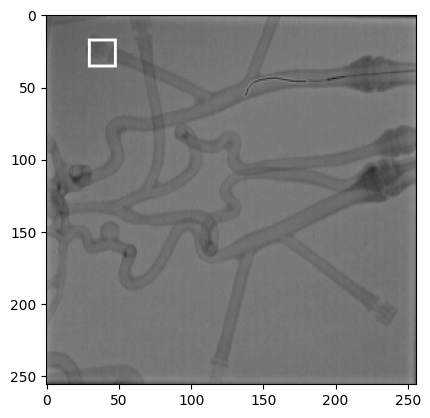

In [7]:
env.reset()
for i in range(500):
    img, reward, is_done, _ = env.step(random.choice([0, 1, 2, 3]))  # 执行一个动作（0: 推进， 1： 撤回， 2，3：旋转）
    print(i, reward, is_done, _[0])
    if is_done:
        break
plt.imshow(img[0], cmap='gray') 

([113, 276], [79, 54])

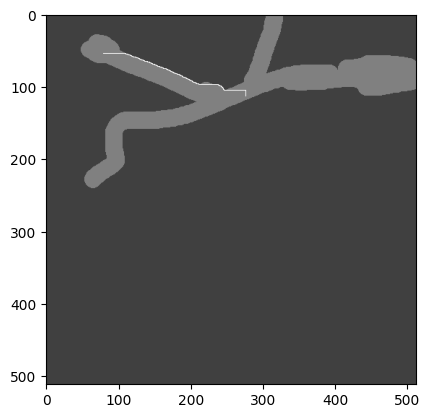

In [8]:
plt.imshow(env._mask_surf_np, cmap='gray', alpha=0.5)
plt.imshow(env.a_star_path_np, cmap='gray', alpha=0.5)

env.get_now_tip_pos(), env.metadata.target_pos

In [7]:
def l2_distance(point1, point2):
    """
    没有开根的欧氏距离 (为了优化计算速度)
    """
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) ** 0.5

In [9]:
import numpy as np
import math

( np.sum(env.a_star_path_np), 
 l2_distance(env.get_now_tip_pos(), env.metadata.target_pos),
 -math.log( np.sum(env.a_star_path_np) * 0.001 ))

(241, 297.43570733857763, 1.422958345491482)

In [6]:
env._mask_surf_np.shape

(512, 512, 3)

我们的目标是训练一个AI，能够根据图像输入学习到将导丝推送到目标位置（白框）

## 需要尽可能的提升增加泛化性

这个仿真器提供了多种不同的任务，包括不同形状和大小的目标，不同难度的背景，不同难度的导丝路径

## 尝试使用Qwen2.5VL


In [70]:
from agents.qwen_vl import Agent

In [71]:
openai_api_key = "EMPTY"
openai_api_base = "http://192.168.1.110:1234/v1"
model="qwen2.5-vl-7b-instruct"
agent = Agent(openai_api_key, openai_api_base, model)

In [72]:
chat_response = agent.chat_with_array(img[0],
                    "将导丝递送到白框位置，你可以推进，后退，左转和右转，请输出你认为的导丝动作选择")  # 与agent对话
plt.imshow(img[0], cmap='gray')

APIConnectionError: Connection error.

In [18]:
chat_response.choices[0].message.content  # 获取回复内容

'根据图像显示的信息，导丝已经到达了白框的位置。因此，在这种情况下，不需要进行任何操作来移动或调整导丝。导丝已经在目标位置，可以保持不动。\n\n所以，正确的答案是：无需进行任何操作（即“静止”）。'